# Build Stock Prices Dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

In [2]:
sns.set(font_scale=1.5)

In [3]:
const_df = pd.read_csv("../data/constituents.csv").sort_values(by="Symbol")
const_df = const_df.rename(columns={"GICS Sector": "GICS_Sector"})

In [4]:
ticker = "AAPL"
start_date = '2000-01-01'
end_date = '2019-12-31'

In [5]:
# # Download data.
# price_df = yf.download(ticker, start_date, end_date).reset_index(drop=False)

In [6]:
# # Write the data.
# price_df.to_csv(f"../data/{ticker}.csv", index=False)

In [7]:
# Load data.
price_df = pd.read_csv(f"../data/{ticker}.csv", parse_dates=["Date"])

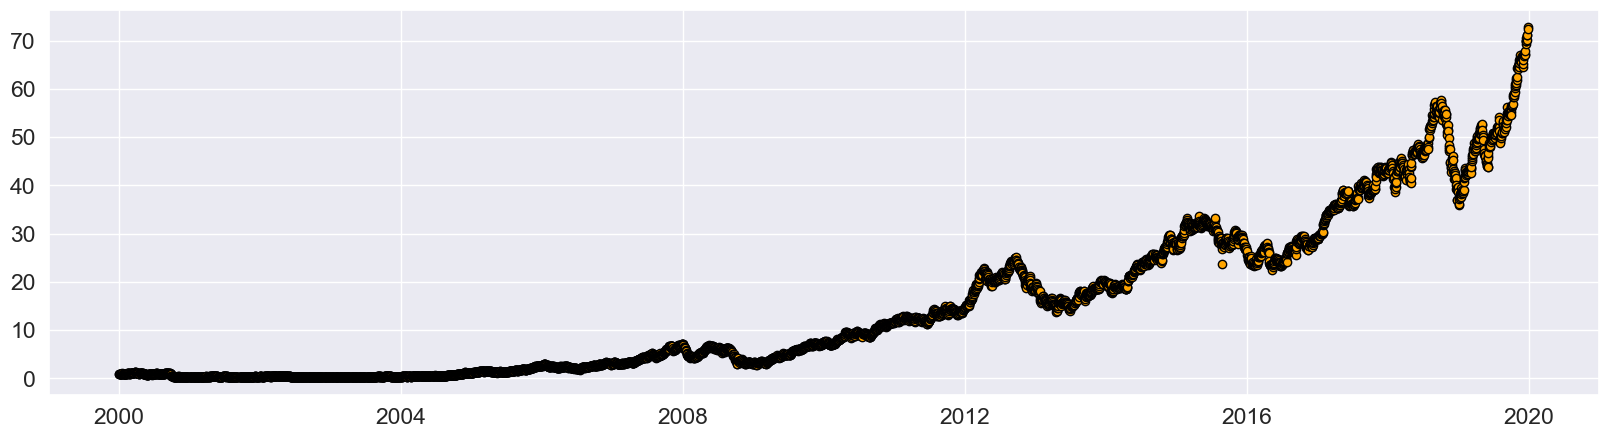

In [8]:
plt.figure(figsize=(20, 5))
plt.scatter(price_df.Date, price_df.Open, edgecolor="black", color="orange")
plt.show()

In [9]:
# Build a model that get data from the past 10 days. It has to predict if day 11 the price is up or down.
# Given 10 past days, predict if today it closes up.

In [10]:
# Add a return column.
price_df["Return"] = price_df.Close.pct_change()
price_df["Return"] = price_df["Return"].fillna(0)

In [11]:
# Add a target column.
target = np.zeros((price_df.shape[0], ))
target[price_df.Return.values>0] = 1
price_df["Target"] = target

In [12]:
# Build X array.
n_days = 10
vector = price_df.Close.values
X = np.lib.stride_tricks.sliding_window_view(vector[0:-1], window_shape=(n_days,))

# Build y array.
y = price_df.Target.values[n_days:]

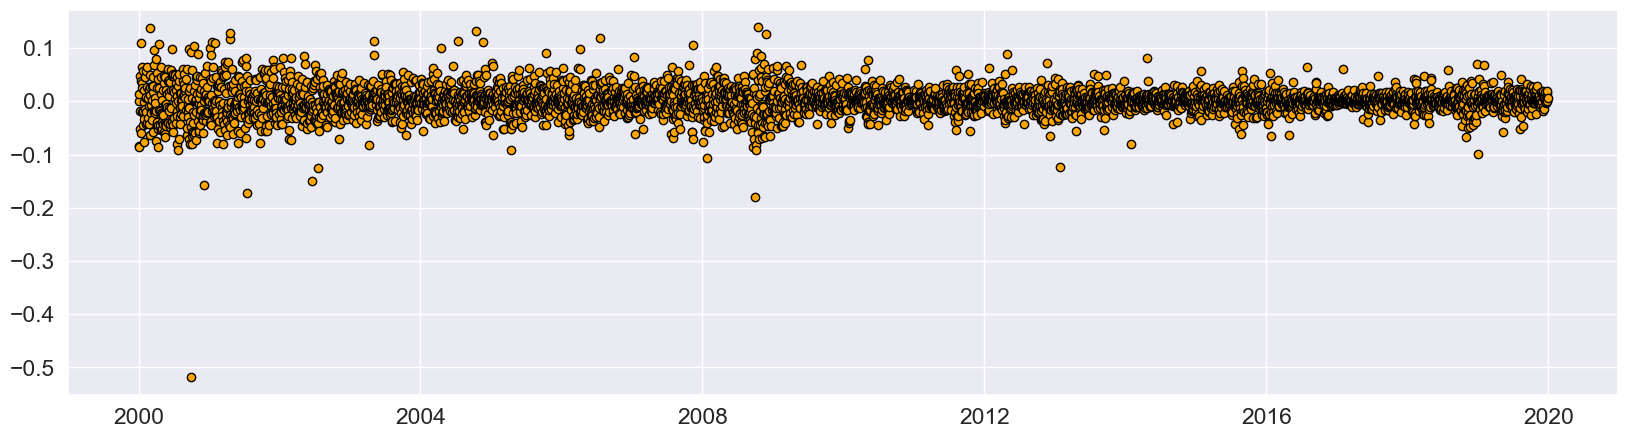

In [13]:
# plot the returns.
plt.figure(figsize=(20, 5))
plt.scatter(price_df.Date, price_df.Return, edgecolor="black", color="orange")
plt.show()

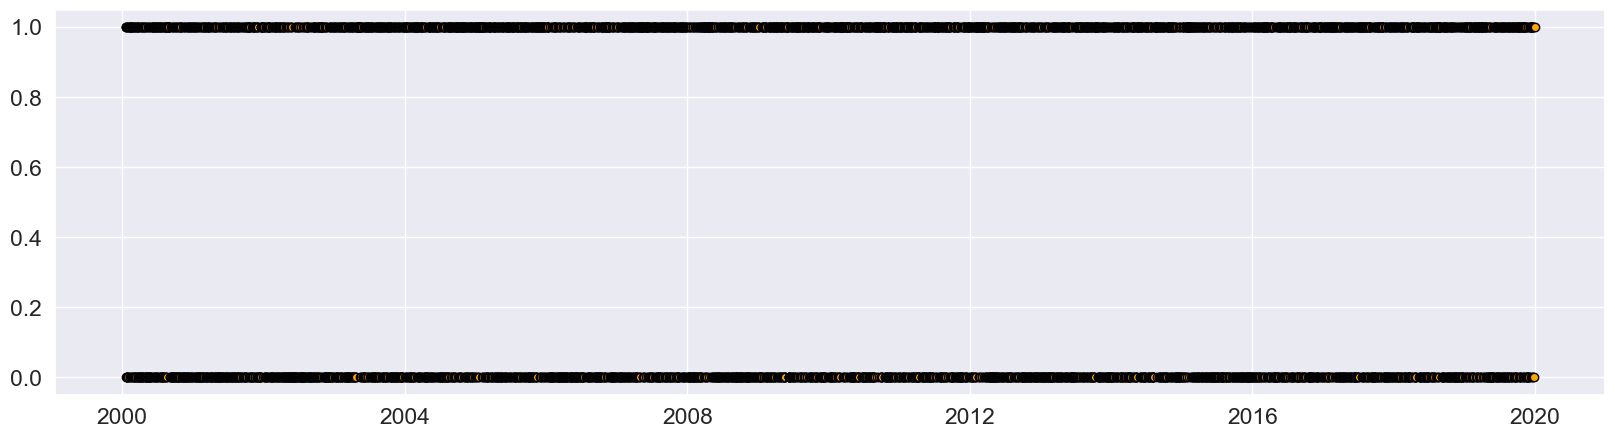

In [14]:
plt.figure(figsize=(20, 5))
plt.scatter(price_df.Date.values[n_days:], y, edgecolor="black", color="orange")
plt.show()

In [15]:
X_train = X[0:4500]
y_train = y[0:4500]

X_val = X[4500:5000]
y_val = y[4500:5000]

X_test = X[5000:]
y_test = y[5000:]

print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5020, 10)
(4500, 10)
(500, 10)
(20, 10)


In [16]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf = clf.fit(X_train, y_train)

In [17]:
print(clf.score(X_train, y_train))
print(clf.score(X_val, y_val))
print(clf.score(X_test, y_test))

0.5522222222222222
0.476
0.3


## Add features.
As additional features, take stock price of companies in the same GICS sector.

In [18]:
ticker = "AAPL"

In [19]:
sector = const_df.query("Symbol == @ticker")["GICS_Sector"].values[0]
sector_df = const_df.query("GICS_Sector == @sector")

In [20]:
sector_df.shape

(67, 8)

In [21]:
tickers = list(sector_df.Symbol.values)

In [22]:
# # Get data for all the above tickers.

# # Download and write data.
# for ticker in tickers:
#     (
#         yf
#         .download(ticker, start_date, end_date).reset_index(drop=False)
#         .to_csv(f"../data/{ticker}.csv", index=False)
#     )

In [23]:
# Build a dataset with the close price for all the stocks in the sector.

from functools import reduce

dataframes = []
for ticker in tickers:
    tmp_df = pd.read_csv(f"../data/{ticker}.csv")[["Date", "Close"]]
    tmp_df = tmp_df.rename(columns={"Close": f"{ticker}_Close"})
    if tmp_df.shape[0] == 0:
        continue
    dataframes.append(tmp_df)

# join all the dataframes.
joined_df = reduce(lambda left, right: pd.merge(left, right, on="Date", how="outer"), dataframes)

In [24]:
# Drop the columns with nulls.
print(joined_df.shape)
cols_with_null = list(joined_df.columns[joined_df.isnull().any()])
joined_df = joined_df.drop(cols_with_null, axis=1)
print(joined_df.shape)

(5030, 65)
(5030, 45)


In [25]:
# Compute correlation coefficients.
tmp_df = joined_df.drop("Date", axis=1)
matrix = tmp_df.corr()

In [26]:
# Get stocks tickers that are correlated with the ticket of interest.
series = matrix[f"{ticker}_Close"]
cols_list = list(series[series > .85].index)
print(len(cols_list))
cols_list = ["Date"] + cols_list
price_df = joined_df[cols_list].copy()

21


In [27]:
# Add a return column.
price_df["Return"] = price_df[f"{ticker}_Close"].pct_change()
price_df["Return"] = price_df["Return"].fillna(0)

In [28]:
# Add a target column.
target = np.zeros((price_df.shape[0], ))
target[price_df.Return.values>0] = 1
price_df["Target"] = target

In [29]:
# Build X array.
n_days = 10
cols = [col for col in price_df.columns if "Close" in col]
collect_X = []
for col in cols:
    vector = price_df[col].values
    X = np.lib.stride_tricks.sliding_window_view(vector[0:-1], window_shape=(n_days,))
    collect_X.append(X)
X = np.concatenate(collect_X, axis=1)
print(X.shape)

(5020, 210)


In [30]:
# Build y array.
y = price_df.Target.values[n_days:]

In [36]:
X_train = X[0:4800]
y_train = y[0:4800]

X_val = X[4800:5000]
y_val = y[4800:5000]

X_test = X[5000:]
y_test = y[5000:]

print(X.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(5020, 210)
(4800, 210)
(200, 210)
(20, 210)


In [39]:
clf = RandomForestClassifier(max_depth=16, random_state=0)
clf = clf.fit(X_train, y_train)

In [40]:
print(clf.score(X_train, y_train))
print(clf.score(X_val, y_val))
print(clf.score(X_test, y_test))

0.9914583333333333
0.545
0.45
